In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mp
# import gaia_tools as gt
import scipy
from scipy.ndimage import gaussian_filter
import astropy.units as u
from astropy.coordinates import SkyCoord
import math

In [6]:
stars = np.load('C:/Users/dnurm/Desktop/Uni_files/Thesis/.venv/Data/star_particles_pos_5e8.npy') # home PC
#stars = np.load('C:/Data/Praktika_data/star_particles_pos_5e8.npy') #laptop path
starsdf = pd.DataFrame(stars)
starsdf = starsdf.rename(columns={0:"x", 1:"y", 2:"z"})

# to remove outliers in the z axis with np.where, I first need to convert the column to a numeric type with pd.to_numeric.
# z axis is chosen specifically because, if the data is plotted in the x-z axis, the relevant data is clearly bound between -20 and 20 kpc.
# This 

starsdf["z"] = pd.to_numeric(starsdf["z"], errors="coerce")
starsdf['z'] = np.where((starsdf['z'] > 20) | (starsdf['z'] < -20), np.nan, starsdf['z'])
starsdf = starsdf.dropna(subset=["z"])

x_s = starsdf['x']
y_s = starsdf['y']
z_s = starsdf['z']

large_cloud = np.array([x_s, y_s, z_s])

bins = (35, 35)

In [7]:
file = 'C:/Users/dnurm/Desktop/Uni_files/Thesis/.venv/Data/trajlmc.txt'
#file = 'C:/Data/Praktika_data/trajlmc.txt'
orbit = pd.read_csv(file, delimiter=' ')

In [ ]:
today_orbit = orbit.iloc[400]

today = np.array([today_orbit['Vx'], today_orbit['Vy'], today_orbit['Vz']])
today = today # ?????
origin = np.array([today_orbit['x'], today_orbit['y'], today_orbit['z']])



vx, vy, vz = today_orbit['Vx'], today_orbit['Vy'], today_orbit['Vz']
factor = 50  # how long you want the arrow in kpc-units space
length = (vx**2 + vy**2 + vz**2)**0.5
Ux, Uy, Uz = vx/length * factor, vy/length * factor, vz/length * factor
speed = np.array([Ux, Uy, Uz]) 

Functions used in this notebook

In [44]:
# 3D rotation matrixes
def rx(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[1, 0, 0],
                     [0, c,-s],
                     [0, s, c]])
def ry(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[ c, 0, s],
                     [ 0, 1, 0],
                     [-s, 0, c]])
def rz(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c,-s, 0],
                     [s, c, 0],
                     [0, 0, 1]])

def rotate(rot_mat, vec):
    return rot_mat @ vec

#-----------------------------------------------------------------------------------------------------------------

extent = [-60, 60, -60, 60]
def plot_OD_gaussian(x, y, bins, sigma, title, xaxis, yaxis): # x coord, y coord, nr of bins, extent of plot, sigma for gaussian filter, title of plot, x axis title, y axis title
    fig,ax = plt.subplots()
    
    def overdensity(x, y, bins):  # generating the overdensity map
        pre_OD, xedges, yedges = np.histogram2d(x, y, bins)
        OD = (pre_OD / np.mean(pre_OD)-1)
        return OD, xedges, yedges
    
    OD, xedges, yedges = overdensity(x, y, bins) # calling out the function
    im = ax.imshow(OD.T, origin='lower', cmap = "seismic")
    c = plt.colorbar(im, ax=ax)
    plt.title(str(title))
    plt.xlabel(str(xaxis))
    plt.ylabel(str(yaxis))
    c.set_label('difference from average star density', rotation=270, labelpad=20)
    hist_smoothed = gaussian_filter(OD.T, sigma=sigma)
    image = plt.imshow(hist_smoothed, origin='lower', extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="seismic")
    return image

#-----------------------------------------------------------------------------------------------------------------
def angle_between(v1, v2):
    v1_v2 = np.dot(v1, v2)
    mag_v1 = np.linalg.norm(v1)
    mag_v2 = np.linalg.norm(v2)
    angle_Z = np.arccos(v1_v2 / (mag_v1 * mag_v2))
    return np.degrees(angle_Z)

#-----------------------------------------------------------------------------------------------------------------
def sim_rotation(simulation_data, LMC_velocity_components): # simulated data in cartesian coordinates and the x, y, and z components of the LMC velocity vector
    vel_vec_x =(42, 0, 0) # random vector pointing towards x axis. x = 42 because it is the answer to the ultimate question of life, the universe and everything.
    v_LMC = LMC_velocity_components
    angle_2D = angle_between([vel_vec_x[0], vel_vec_x[1]], [v_LMC[0], v_LMC[1]]) # angle between the two vectors in 2D
    
        # -------------------------------------------------------------------------#
    if (((v_LMC[0] < 0) & (v_LMC[1] <= 0 )) | ((v_LMC[0] > 0) & (v_LMC[1] <= 0))):
        angle_2D = -angle_2D
    else:
        angle_2D = angle_2D
        # -------------------------------------------------------------------------#  
           
    rotated_2D = rotate(rz(np.radians(angle_2D)), vel_vec_x) # rotation matrix around z axis

    angle_3D = angle_between(rotated_2D, v_LMC) # angle between the two vectors in 3D
        
        # -------------------------------------------------------------------------#
    if (((v_LMC[0] < 0) & (v_LMC[2] >= 0 )) | ((v_LMC[0] > 0) & (v_LMC[2] <= 0 ))): # to determine the direction of rotation
        angle_3D = -angle_3D
    else:
        angle_3D = angle_3D
        # -------------------------------------------------------------------------#
    
    R = rz(math.radians(angle_2D)) @ ry(math.radians(angle_3D)) # rotation matrix around z axis and then y axis
    return rotate(R, simulation_data) # rotated simulation data
     




Mock wake generator

In [23]:
# Mock wake generator
def generate_mock_wake(
    
    N_total=300_000,
    box_half_size=300.0,                 # kpc; box is [-L, L]^3
    f_overdense=0.25,                    # fraction of particles in wake component
    mu=(-30.0, 5.0, 0.0),                # kpc; wake center (x0, y0, z0)
    sigma_major=100.0,                    # kpc; wake length-scale along major axis
    sigma_minor=50.0,                    # kpc; width in the orthogonal in-plane axis
    sigma_z=8.0,                         # kpc; thickness
    theta_deg=0.0,                       # rotation of wake in XY plane (deg)
    rng_seed=7
):
    """
    Return a structured ndarray with fields: x,y,z,component (1=wake, 0=bg).
    """
    rng = np.random.default_rng(rng_seed)
    N_over = int(N_total * f_overdense)
    N_bg   = N_total - N_over
    mu = np.asarray(mu, dtype=float)

    # Rotation in the XY plane
    theta = np.deg2rad(theta_deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s],
                  [s,  c]])

    # Covariance in XY for the anisotropic Gaussian
    Lambda_xy = np.diag([sigma_major**2, sigma_minor**2])
    Sigma_xy  = R @ Lambda_xy @ R.T

    # Wake samples
    xy_over = rng.multivariate_normal(mean=mu[:2], cov=Sigma_xy, size=N_over)
    z_over  = rng.normal(loc=mu[2], scale=sigma_z, size=N_over)

    # Clip to keep inside box
    xy_over[:, 0] = np.clip(xy_over[:, 0], -box_half_size, box_half_size)
    xy_over[:, 1] = np.clip(xy_over[:, 1], -box_half_size, box_half_size)
    z_over        = np.clip(z_over,        -box_half_size, box_half_size)

    # Uniform background
    x_bg = rng.uniform(-box_half_size, box_half_size, size=N_bg)
    y_bg = rng.uniform(-box_half_size, box_half_size, size=N_bg)
    z_bg = rng.uniform(-box_half_size, box_half_size, size=N_bg)

    # Concatenate positions
    x = np.concatenate([xy_over[:, 0], x_bg])
    y = np.concatenate([xy_over[:, 1], y_bg])
    z = np.concatenate([z_over,        z_bg])

    # Pack catalog
    comp = np.concatenate([np.ones(N_over, dtype=np.int8),
                           np.zeros(N_bg, dtype=np.int8)])  # 1=wake, 0=bg
    

    cat = np.zeros(N_total, dtype=[('x','f4'),('y','f4'),('z','f4'),('component','i1')])
    
    cat['x'], cat['y'], cat['z']   = x, y, z
    cat['component'] = comp
    return cat


LMC sim data is given in such a way that the velocity vector $v_{tot}$ of the simulation is positioned in such a way that it points towards the $x$-axis. 

* 1) Find the angle between the velocity vector $v_{tot}$ and $v_{LMC}$ (the velocity vector of the real/simulated LMC). This is done in two steps:
    * 1.1) Find the 2D angle between $v_{tot}$ and $v_{LMC}$ using only the $x$ and $y$ components. 
    * 1.2) find the 3D angle using all three velocity vector components. 
* This will give you the two angles you need to rotate the LMC simulation in order to match the LMC position and velocity of your reference. 

* 2) Next you will rotate the simulation using the two angles. $R = R_1 @ R_2$ where $R_1$ is the first rotation around the $z$-axis, $R_2$ is the second rotation around the $y$-axis and $R$ is the matrix to rotate the simulation to the correct position. 

In [51]:
LMC_rotated = sim_rotation(large_cloud, (1, 1, 0))

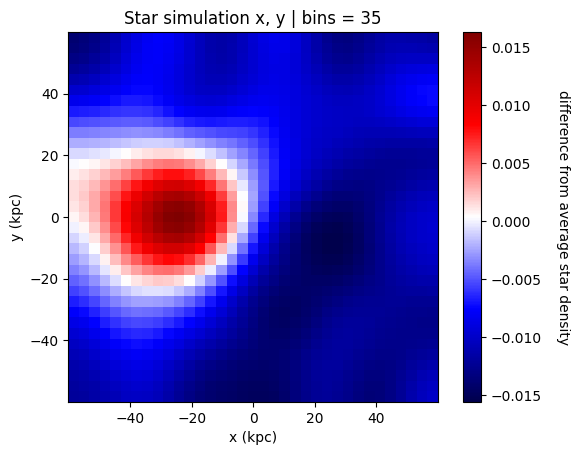

In [52]:
plot_OD_gaussian(large_cloud[0], large_cloud[1], (35, 35), 3, 'Star simulation x, y | bins = 35', 'x (kpc)', 'y (kpc)')

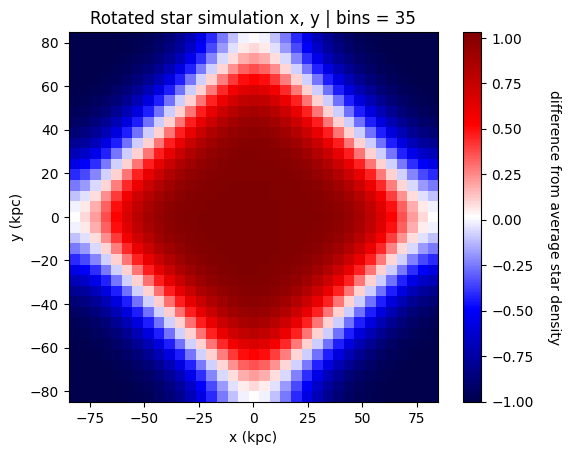

In [53]:
plot_OD_gaussian(LMC_rotated[0], LMC_rotated[1], (35, 35), 3, 'Rotated star simulation x, y | bins = 35', 'x (kpc)', 'y (kpc)')

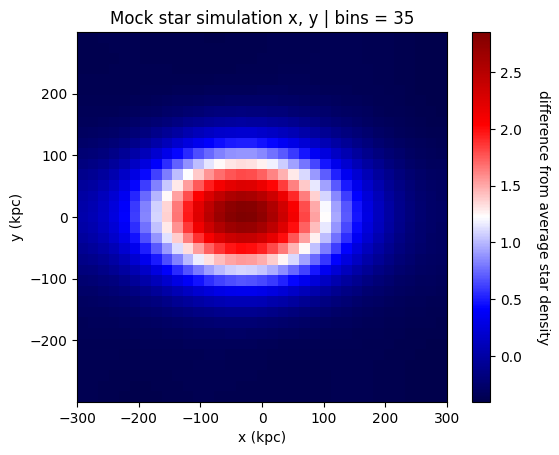

In [25]:
result = generate_mock_wake()
df = pd.DataFrame(result)
coords = df[['x', 'y', 'z']].values
x_sim = result['x']
y_sim = result['y']
z_sim = result['z']

sim = np.array([x_sim, y_sim, z_sim])

plot_OD_gaussian(x_sim, y_sim, (35, 35), 3, 'Mock star simulation x, y | bins = 35', 'x (kpc)', 'y (kpc)')

In [36]:
sim_rot = sim_rotation(sim, [1, 1, 0])

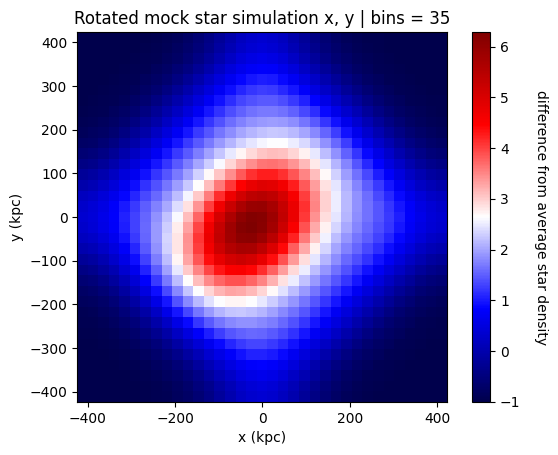

In [37]:
plot_OD_gaussian(sim_rot[0], sim_rot[1], (35, 35), 3, 'Rotated mock star simulation x, y | bins = 35', 'x (kpc)', 'y (kpc)')

In [38]:
today

array([ -63.9522, -214.517 ,  206.584 ])